## Comparing the variation in mRNA-protein correlation explained by transcriptomic and proteomic reproducibility 

**Input:** 
<ul>
    <li> Transcriptomic reprouducibility correlation</li>
    <li> Aggregated protein reproducibility rank</li>
    <li> Processed mRNA-protein correlation of all studies (Table S1)</li>
</ul>          

#### Import Packages

In [1]:
import os, re
import numpy as np 
import pandas as pd
import matplotlib as mpl
%matplotlib inline
import customized_plots
import common_utils as cu
import graphing_utils as gu

In [2]:
get_data_path = lambda folders, fname: os.path.normpath(os.environ['DATA_PATH']+'/'+'/'.join(folders) +'/'+ fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/'+'/'+'/'.join(folders) +'/'+ fname)

In [3]:
file_mRNA_protein_correlation = get_local_data_path(['results'], 'TableS1.xlsx')
file_protein_reproducibility_ranks = get_local_data_path(['results'], 'TableS2.xlsx')
file_transcriptomic_reproducibility_cor = get_local_data_path(['processed', 'correlation_replicates'], 
                                                              'transcriptomic_reproducibility.xlsx')
file_ccle_residuals = get_local_data_path(['processed', 'gsea'], 'ccle_transcriptomic_resid.csv')

#### Load data

In [4]:
mRNA_protein_correlation = pd.read_excel(file_mRNA_protein_correlation, sheet_name='A. mRNA-protein correlation', 
                                         index_col=0)
mRNA_protein_correlation[:2]

,CRC (2014),BrCa (2016),Ovarian,Colon,ccRCC,EC,LUAD,BrCa (2020),HNSCC,GBM,NCI60,CCLE,GTEx
Gene symbol,,,,,,,,,,,,,
A1BG,0.123133,-0.093805,-0.078889,NaN,0.035573,0.324974,-0.119663,0.077242,0.065872,-0.192863,NaN,NaN,0.154523
A1CF,NaN,NaN,NaN,0.673548,0.908613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.188605


In [5]:
crc14 = mRNA_protein_correlation['CRC (2014)'].copy(deep=True).dropna()
brca16 = mRNA_protein_correlation['BrCa (2016)'].copy(deep=True).dropna()
ovca = mRNA_protein_correlation['Ovarian'].copy(deep=True).dropna()
crc19 = mRNA_protein_correlation['Colon'].copy(deep=True).dropna()
ccrcc = mRNA_protein_correlation['ccRCC'].copy(deep=True).dropna()
ec = mRNA_protein_correlation['EC'].copy(deep=True).dropna()
luad = mRNA_protein_correlation['LUAD'].copy(deep=True).dropna()
brca20 = mRNA_protein_correlation['BrCa (2020)'].copy(deep=True).dropna()
hnscc = mRNA_protein_correlation['HNSCC'].copy(deep=True).dropna()
gbm = mRNA_protein_correlation['GBM'].copy(deep=True).dropna()
ccle = mRNA_protein_correlation['CCLE'].copy(deep=True).dropna()
gtex = mRNA_protein_correlation['GTEx'].copy(deep=True).dropna()

In [6]:
aggregated_rank = pd.read_excel(file_protein_reproducibility_ranks, sheet_name='B. Protein reproducibility rank', 
                                index_col=0, usecols=['Unnamed: 0', 'Aggregated Reproducibility Rank'], 
                                squeeze=True).dropna()
aggregated_rank[:2]

A1BG    0.575671
A2M     0.501120
Name: Aggregated Reproducibility Rank, dtype: float64

In [7]:
correlation_transcriptomics = pd.read_excel(file_transcriptomic_reproducibility_cor, sheet_name='Reproducibility', 
                                            usecols=['Unnamed: 0', 'CCLE-Klijn'], index_col=0, squeeze=True).dropna()
correlation_transcriptomics[:2]

A1BG      0.758553
A4GALT    0.866460
Name: CCLE-Klijn, dtype: float64

In [8]:
from matplotlib import pyplot as plt
plt.style.use(['seaborn-white'])
import seaborn as sns

In [9]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib_venn import venn2

In [10]:
def ols_fit(x, y, match_subsets=True):
    x_subset, y_subset = cu.get_matched_index(x, y) 
    est = sm.OLS(y_subset, sm.add_constant(x_subset.astype(float))).fit()
    return est

In [11]:
all_studies = [brca16, ccrcc, ccle, ovca, crc19, crc14, brca20, gtex, ec, luad, hnscc, gbm]

In [12]:
def plot_venn(set1, set2, ax, title, labels):
    plot = venn2([set1, set2], ax=ax, set_colors=['#ddaa33', '#004488'], set_labels=labels)
    for text in plot.set_labels:
        text.set_fontsize(14)
    for text in plot.subset_labels:
        text.set_fontsize(14)
    ax.set_title(title)
    
sample_title = '# of Samples'
proteins_title = '# of Proteins'

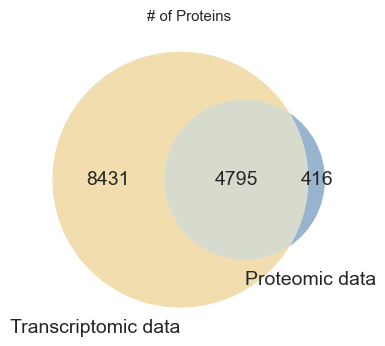

In [13]:
labels=['Transcriptomic data', 'Proteomic data']
figure, axes = plt.subplots(1,1)
plot_venn(set(correlation_transcriptomics.index), set(aggregated_rank.index), axes, proteins_title, labels)

#### A. Analysing the variation in mRNA-protein correlation explained by transcriptomic and proteomic reproducibility

In [14]:
# Ensuring regressing both factors for the same number of proteins
combined_df = pd.concat([aggregated_rank, correlation_transcriptomics], axis=1, join='inner')
combined_df.columns=['Aggregated Ranks', 'Transcriptomic replicate correlation']
print("Number of common proteins between CCLE transcriptomic and aggregated data: ", len(combined_df))

Number of common proteins between CCLE transcriptomic and aggregated data:  4795


In [15]:
assert combined_df.isnull().sum().sum() == 0

In [16]:
rsquared_transcriptomic = {}
rsquared_aggregated_rank = {}
rsquared_transcriptomic_aggregated_rank = {}
print("Regressing mRNA-protein correlation using protein or transcriptomic reproducibility factors")
for study in all_studies: 
    rsquared_transcriptomic[study.name] = round(ols_fit(x=combined_df['Transcriptomic replicate correlation'], 
                                                        y=study).rsquared_adj*100, 2)
    rsquared_aggregated_rank[study.name] = round(ols_fit(x=combined_df['Aggregated Ranks'], y=study).rsquared_adj*100, 2)
    
    rsquared_transcriptomic_aggregated_rank = {}

print("Regressing mRNA-protein correlation using CCLE Transcriptomic and Aggregated subset")
for study in all_studies: 
    rsquared_transcriptomic_aggregated_rank[study.name] = round(ols_fit(x=combined_df, y = study).rsquared_adj * 100, 2)

Regressing mRNA-protein correlation using protein or transcriptomic reproducibility factors
Regressing mRNA-protein correlation using CCLE Transcriptomic and Aggregated subset


In [17]:
args = gu.additional_plot_parameters(xlab="CCLE - Klijn Transcriptomic Correlation", ylab="Density")

In [18]:
proteins_count = {study.name: len(combined_df[combined_df.index.isin(study.index)]) for study in all_studies}
r2_reproducibility_ranks = cu.dataframe_from_dict(['CCLE Transcriptomic\nReproducibility', 
                                  'Aggregated Protein\nReproducibility Rank', 
                                  'CCLE Transcriptomic +\nAggregated Protein\nReproducibility Rank', 'Proteins Count'], 
                                 rsquared_transcriptomic, rsquared_aggregated_rank,
                                 rsquared_transcriptomic_aggregated_rank, proteins_count, 
                                                  repeat_factor=len(rsquared_transcriptomic))

Factor,Data,Aggregated Protein\nReproducibility Rank,CCLE Transcriptomic\nReproducibility,CCLE Transcriptomic +\nAggregated Protein\nReproducibility Rank,Proteins Count
0,BrCa (2016),11.59,8.01,14.40,4067
1,BrCa (2020),15.60,17.64,24.36,4489
2,CCLE,25.01,40.33,48.72,4676
3,CRC (2014),22.04,8.96,23.99,2761
4,Colon,17.46,10.37,20.62,4014
5,EC,19.15,16.31,26.14,4746
6,GBM,15.24,16.84,23.66,4721
7,GTEx,16.27,16.88,24.41,4479
8,HNSCC,15.36,13.29,21.09,4723
9,LUAD,14.92,11.41,19.47,4418


In [19]:
get_order = lambda df: df.groupby(by=['Data']).sum().sort_values('R-squared').index.values

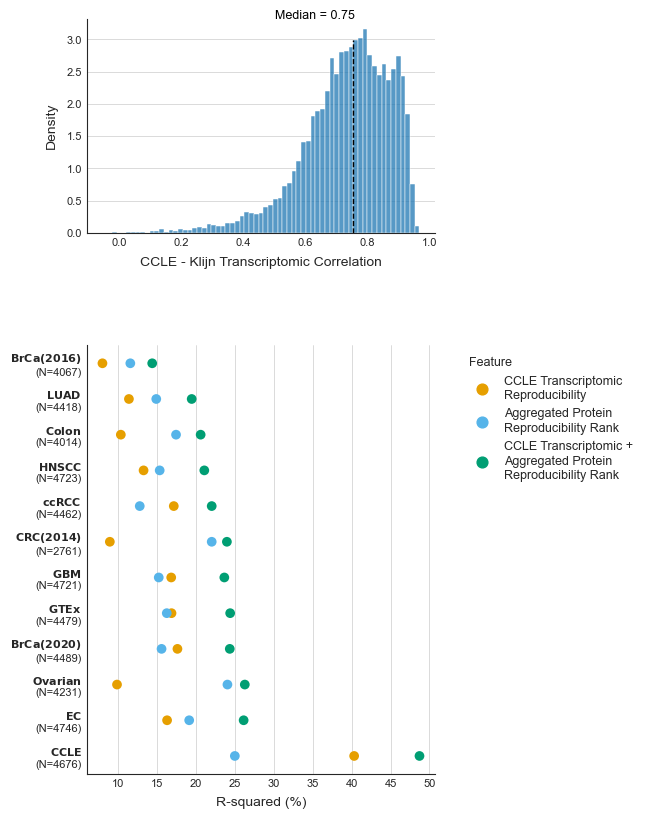

In [20]:
with plt.rc_context({'axes.spines.right': False, 'axes.spines.top': False,'axes.spines.left': True, 
                     'axes.linewidth': 0.8, 'xtick.bottom': True}):
    figure, axes = plt.subplots(2, 1, figsize=(4.5,10), gridspec_kw={'height_ratios': [1.25, 2.5]})
    customized_plots.draw_histogram(axes[0], correlation_transcriptomics, args)
    customized_plots.draw_dotplot(ax=axes[1], x='R-squared', y='Data', data=r2_reproducibility_ranks, hue='Factor',  
                                  order=get_order(r2_reproducibility_ranks),
                                  args=gu.additional_plot_parameters(xlab="R-squared (%)", ylab=None, 
                                                                     yaxis_grid=False, xaxis_grid=True,  
                                                                     palette=['#E69F00', '#56B4E9', 
                                                                              '#009E73', '#0072B2'],
                                                                     anchor_legend_at=(1.6, 1)))
    plt.subplots_adjust(hspace=0.35)
#     figure.savefig('../figures/Figure6.svg', bbox_inches='tight', dpi=300)

#### B. Performing Likelihood ratio test to ensure the models with just transcriptomic / proteomic data are different from the combined model

In [21]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [22]:
def lrtest(llmin, llmax):
    lr = 2 * (llmax - llmin)
    p = stats.chisqprob(lr, 1) # llmax has 1 dof more than llmin
    return lr, p

In [23]:
for study in all_studies: 
    print(study.name)
    llf_transcriptomic = ols_fit(x=combined_df['Transcriptomic replicate correlation'], y = study).llf
    llf_proteomic = ols_fit(x=combined_df['Aggregated Ranks'], y = study).llf
    llf_combined = ols_fit(x=combined_df, y=study).llf    
    
    lr, p = lrtest(llf_transcriptomic, llf_combined)
    print('Transcriptomic v/s combined model : LR test statistic = {:.2f},  p value = {:.5g}'.format(lr, p))
    lr, p = lrtest(llf_proteomic, llf_combined)
    print('Proteomic v/s combined model : LR test statistic = {:.2f},  p value = {:.5g}\n'.format(lr, p))

BrCa (2016)
Transcriptomic v/s combined model : LR test statistic = 293.86,  p value = 7.162e-66
Proteomic v/s combined model : LR test statistic = 132.15,  p value = 1.3905e-30

ccRCC
Transcriptomic v/s combined model : LR test statistic = 271.36,  p value = 5.7355e-61
Proteomic v/s combined model : LR test statistic = 500.64,  p value = 6.8969e-111

CCLE
Transcriptomic v/s combined model : LR test statistic = 710.17,  p value = 1.8329e-156
Proteomic v/s combined model : LR test statistic = 1778.64,  p value = 0

Ovarian
Transcriptomic v/s combined model : LR test statistic = 851.24,  p value = 3.9109e-187
Proteomic v/s combined model : LR test statistic = 126.80,  p value = 2.0495e-29

Colon
Transcriptomic v/s combined model : LR test statistic = 488.37,  p value = 3.23e-108
Proteomic v/s combined model : LR test statistic = 157.80,  p value = 3.4256e-36

CRC (2014)
Transcriptomic v/s combined model : LR test statistic = 499.04,  p value = 1.5385e-110
Proteomic v/s combined model : L

<div class="alert alert-block alert-success">
    Based on the above results where p < 0.001, we understand that the combined model is better than the individual model for all the studies considered</div

### C. 18 random cancer cell lines 

In [24]:
correlation_random_transcriptomics = pd.read_excel(file_transcriptomic_reproducibility_cor, index_col=0,
                                            sheet_name='Random Reproducibility')
correlation_random_transcriptomics[:2]

,Iteration0,Iteration1,Iteration2,Iteration3,Iteration4,Iteration5,Iteration6,Iteration7,Iteration8,Iteration9,...,Iteration90,Iteration91,Iteration92,Iteration93,Iteration94,Iteration95,Iteration96,Iteration97,Iteration98,Iteration99
A1BG,0.690725,0.844931,0.423109,0.582118,0.623627,0.846745,0.595515,0.804457,0.852000,0.726556,...,0.528302,0.615976,0.525622,0.636077,0.727915,0.727572,0.873887,0.716322,0.884726,0.743724
A4GALT,0.879610,0.939398,0.853052,0.824688,0.941035,0.917621,0.556714,0.844312,0.860088,0.898034,...,0.813951,0.923078,0.891868,0.685732,0.933743,0.937932,0.944139,0.738310,0.725518,0.914706


In [25]:
rsquared_random_transcriptomic = dict.fromkeys([study.name for study in all_studies], 0)

for i in range(99):
    combined_df = pd.concat([aggregated_rank, correlation_random_transcriptomics['Iteration'+str(i+1)]], 
                            axis=1, join='inner')
    combined_df.columns=['Aggregated Ranks', 'Transcriptomic reproducibility']
    assert combined_df.isnull().sum().sum() == 0
    for study in all_studies:
        rsquared_random_transcriptomic[study.name] = rsquared_random_transcriptomic[study.name] + \
                                            round(ols_fit(x=combined_df['Transcriptomic reproducibility'], 
                                                        y=study).rsquared_adj*100, 2)

In [26]:
for study in all_studies:
    rsquared_random_transcriptomic[study.name] = rsquared_random_transcriptomic[study.name] / 100

In [27]:
proteins_count = {study.name: len(combined_df[combined_df.index.isin(study.index)]) for study in all_studies}
r2_random_aggregated = cu.dataframe_from_dict(['CCLE Random\nTranscriptomic Reproducibility', 
                                               'Aggregated Protein\nReproducibility Rank', 'Proteins Count'], 
                       rsquared_random_transcriptomic, rsquared_aggregated_rank,proteins_count,
                       repeat_factor=len(rsquared_random_transcriptomic))
r2_random_aggregated = r2_random_aggregated.pivot(index='Data',values='R-squared', 
                                                  columns='Factor').rename(columns=lambda x: re.sub('\n', ' ', x))
r2_random_aggregated['Times'] = r2_random_aggregated['Aggregated Protein Reproducibility Rank'] / \
                                r2_random_aggregated['CCLE Random Transcriptomic Reproducibility']

Factor,Data,Aggregated Protein\nReproducibility Rank,CCLE Random\nTranscriptomic Reproducibility,Proteins Count
0,BrCa (2016),11.59,3.6921,4067
1,BrCa (2020),15.60,8.0546,4489
2,CCLE,25.01,18.0312,4676
3,CRC (2014),22.04,4.0090,2761
4,Colon,17.46,4.6819,4014
5,EC,19.15,7.5033,4746
6,GBM,15.24,7.5888,4721
7,GTEx,16.27,7.5959,4479
8,HNSCC,15.36,6.1327,4723
9,LUAD,14.92,5.2468,4418


In [28]:
r2_random_aggregated['Times'].mean()

2.9034579621693073